<a href="https://colab.research.google.com/github/solvedbrunus/lab-lora-tuning-peft/blob/main/lab_lora_tuning_peft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

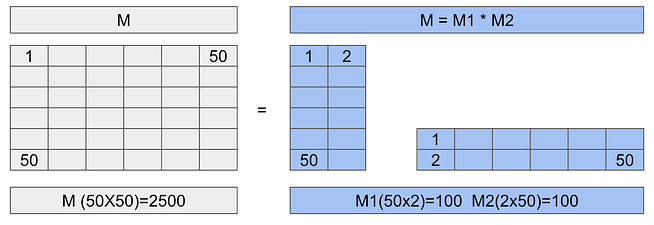

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
!pip install -q peft
!pip install -q datasets==2.16.1
!pip install ipywidgets==7.7.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.10.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterl

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [25]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloomz-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name, device_map='cuda')
foundation_model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map='cuda')

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-3.2-1B.
401 Client Error. (Request ID: Root=1-678e829e-304af93c5dd01de77a6fa6b1;02d862e5-8826-4594-8b7f-ae407c88a850)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.2-1B/resolve/main/config.json.
Access to model meta-llama/Llama-3.2-1B is restricted. You must have access to it and be authenticated to access it. Please log in.

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [26]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=1000): #play with this function inputs and see if you get something interesting
    outputs = foundation_model.generate(
            input_ids=input_sentences["input_ids"],
            attention_mask=input_sentences["attention_mask"],
            max_length=100,
            num_beams=5,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.5,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id
        )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [4]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach. Don't be afraid of being challenged", return_tensors="pt", padding=True)
input_sentences = {k: v.to('cuda') for k, v in input_sentences.items()}
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=1000)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=False))


["I want you to act as a motivational coach. Don't be afraid of being challenged. Don't be afraid of being criticized. Don't be afraid of being wrong. Don't be afraid of being alone. Don't be afraid of being scared. Don't be afraid of being lonely. Don't be afraid of being alone. Don't be afraid of being alone. Don't be afraid of being alone. Don't be afraid of being alone. Don't be afraid of being alone. Don't be afraid of being alone. Don't be afraid of being"]


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [5]:
!pip install datasets

In [6]:
from datasets import load_dataset

# Correct the dataset name (repo name, not URL)
dataset = "fka/awesome-chatgpt-prompts"

# Load dataset directly from HuggingFace
data = load_dataset(dataset)

# Process the dataset
data = data.map(lambda samples: tokenizer(samples['prompt']), batched=True)
train_sample = data['train'].select(range(50))

# Remove unwanted columns
train_sample = train_sample.remove_columns('act')
display(train_sample)

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [7]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

# Fine-Tuning.
First is necesary create a LoRA config.


In [8]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [9]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 700,416 || all params: 1,065,904,128 || trainable%: 0.0657
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [10]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [11]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=True
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [19]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer,
        mlm=False,
        # Add these parameters to handle batch size
        pad_to_multiple_of=8,  # Helps with memory efficiency
        return_tensors="pt"
    )
)

In [13]:
training_args = TrainingArguments(
    per_device_train_batch_size=4,  # Reduce this if still getting memory errors
    gradient_accumulation_steps=4,   # Increase this to compensate for smaller batch size
    max_grad_norm=0.3,              # Add gradient clipping
    learning_rate=2e-4,
    max_steps=100,                  # Adjust as needed
    save_total_limit=3,
    logging_steps=10,
    output_dir="./output"
)

In [14]:
peft_model.gradient_checkpointing_enable()  # Add this before creating the Trainer

In [20]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [21]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [22]:
input_sentences = tokenizer("You are a motivational coach", return_tensors="pt")
input_sentences = {k: v.to('cuda') for k, v in input_sentences.items()}
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=500)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['You are a motivational coach']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

In [29]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "meta-llama/Llama-3.3-70B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct.
401 Client Error. (Request ID: Root=1-678e8340-4e2a5e5c6a248a333e33904c;7d9d5093-6905-41cc-ac6f-f113491365ca)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json.
Access to model meta-llama/Llama-3.3-70B-Instruct is restricted. You must have access to it and be authenticated to access it. Please log in.

In [31]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

In [32]:
#Inference original model
input_sentences = tokenizer("You are a motivati ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:2134: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

In [ ]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.01, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

In [ ]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

In [ ]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In [ ]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=8, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 5e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    evaluation_strategy="no",
    eval_steps=10,
    logging_steps=10,
    save_steps=20,
    use_cpu=True
)

In [ ]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

In [ ]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [ ]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

In [ ]:
input_sentences = tokenizer("YOUR QUERY GOES HERE", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

I tried to run it but i difficulties, some of the results when run in class with the teacher. There was an improvement in generating contextual motivational coaching responses.